In [2]:

import pandas as pd
import matplotlib.pyplot as plt


from src.quantlib_rag.rag.quantlib_assistant import QuantLibQuoteAssistant
from src.quantlib_rag.rag.quantlib_cloud_assistant import QuantLibCloudAssistant
from src.quantlib_rag.rag.quantlib_rag_evaluator import QuantLibRAGEvaluator
from src.quantlib_rag.rag.llm_groq import create_groq_llm
from src.quantlib_rag.config import *

%matplotlib inline

In [3]:
test_set = [
    {"question": "How do I set up the evaluation date in QuantLib?", "gold_source": "basics.md"},
    {"question": "Which core QuantLib types are typically used when starting a simple pricing example?", "gold_source": "basics.md"},

    {"question": "How do I create a QuantLib Date and convert it from a Python datetime?", "gold_source": "dates.md"},
    {"question": "How can I advance a date by a given number of months using QuantLib?", "gold_source": "dates.md"},

    {"question": "How do I build a leg of fixed cashflows in QuantLib?", "gold_source": "cashflows.md"},
    {"question": "How can I get the payment dates and amounts from a cashflow leg in QuantLib?", "gold_source": "cashflows.md"},

    {"question": "How do I construct an IborIndex in QuantLib?", "gold_source": "indexes.md"},
    {"question": "How can I link an index to a yield term structure in QuantLib?", "gold_source": "indexes.md"},

    {"question": "How do I create a simple fixed-rate bond instrument in QuantLib?", "gold_source": "instruments.md"},
    {"question": "How can I retrieve the NPV of an instrument after assigning a pricing engine in QuantLib?", "gold_source": "instruments.md"},

    {"question": "How do I set a discounting bond pricing engine in QuantLib?", "gold_source": "pricing_engines.md"},
    {"question": "Which pricing engines are commonly used for bond and swap pricing in QuantLib?", "gold_source": "pricing_engines.md"},

    {"question": "How do I build a flat yield term structure in QuantLib?", "gold_source": "termstructures.md"},
    {"question": "How can I bootstrap a zero curve from market instruments in QuantLib?", "gold_source": "termstructures.md"},
]


In [4]:
# LOCAL – Mistral + Chroma/BGE + cache 1:1 (w środku QuantLibQuoteAssistant)
local_assistant = QuantLibQuoteAssistant(
    llm_model="mistral",
    temperature=0.0,
    k_default=DEFAULT_K,
    cache_path=LOCAL_MISTRAL_CACHE,
)

# CLOUD – Groq + Qdrant + Gemini (bez cache)
cloud_assistant = QuantLibCloudAssistant(
    groq_model="llama-3.1-8b-instant",
    temperature=0.0,
    k_default=DEFAULT_K,
)

judge_llm = create_groq_llm(model="llama-3.3-70b-versatile", temperature=0.0)

In [5]:
local_eval_phase1 = QuantLibRAGEvaluator(
    assistant=local_assistant,
    judge_llm=None,         # brak sędziego
    backend_name="local",
    k_default=DEFAULT_K,
)

df_local_phase1 = local_eval_phase1.evaluate_dataset(
    test_set=test_set,
    k=None,             # domyślnie DEFAULT_K
    use_judge=False,    # <-- KLUCZ: lokalnie bez judge
)

df_local_phase1.head()



========== ANALYSIS ==========

Question: How do I set up the evaluation date in QuantLib?

Approx. token overlap: 81.2% of answer tokens appear in context.

API symbols in answer (ql.*):
   {'ql.Date', 'ql.Settings'}

API symbols also in context:
   {'ql.Date', 'ql.Settings'}

API symbols ONLY in answer (potential hallucination):
   None

Sources used by retriever:
  DOC 0: basics.md
  DOC 1: indexes.md
  DOC 2: indexes.md
  DOC 3: indexes.md
  DOC 4: dates.md



========== ANALYSIS ==========

Question: Which core QuantLib types are typically used when starting a simple pricing example?

Approx. token overlap: 89.0% of answer tokens appear in context.

API symbols in answer (ql.*):
   {'ql.Date', 'ql.Settings'}

API symbols also in context:
   {'ql.Date', 'ql.Settings'}

API symbols ONLY in answer (potential hallucination):
   None

Sources used by retriever:
  DOC 0: basics.md
  DOC 1: indexes.md
  DOC 2: indexes.md
  DOC 3: indexes.md
  DOC 4: cashflows.md



========== ANALYSIS =

,backend,question,gold_source,hit_at_k,faithfulness,helpfulness,judge_notes,latency_retrieval_ms,latency_llm_ms,overlap_percent,api_only_in_answer,answer_en
0,local,How do I set up the evaluation date in QuantLib?,basics.md,1,None,None,judge_skipped,444.031477,0.037432,81.250000,[],"To set up the evaluation date in QuantLib, you..."
1,local,Which core QuantLib types are typically used w...,basics.md,1,None,None,judge_skipped,171.404839,63262.821436,89.041096,[],When starting a simple pricing example in Quan...
2,local,How do I create a QuantLib Date and convert it...,dates.md,1,None,None,judge_skipped,158.935308,37111.785650,82.608696,[],To create a QuantLib Date and convert it from ...
3,local,How can I advance a date by a given number of ...,dates.md,1,None,None,judge_skipped,153.903484,68164.381027,76.250000,[],To advance a date by a given number of months ...
4,local,How do I build a leg of fixed cashflows in Qua...,cashflows.md,1,None,None,judge_skipped,235.815048,50570.414543,77.142857,[],"To build a leg of fixed cashflows in QuantLib,..."


In [6]:
cloud_eval_full = QuantLibRAGEvaluator(
    assistant=cloud_assistant,
    judge_llm=judge_llm,
    backend_name="cloud",
    k_default=DEFAULT_K,
)

df_cloud_full = cloud_eval_full.evaluate_dataset(
    test_set=test_set,
    k=None,
    use_judge=True,   # cloud od razu z oceną sędziego
)

df_cloud_full.head()

,backend,question,gold_source,hit_at_k,faithfulness,helpfulness,judge_notes,latency_retrieval_ms,latency_llm_ms,overlap_percent,api_only_in_answer,answer_en
0,cloud,How do I set up the evaluation date in QuantLib?,basics.md,1,5,5,The answer directly follows from the provided ...,465.375900,780.642986,90.000000,[],"To set up the evaluation date in QuantLib, you..."
1,cloud,Which core QuantLib types are typically used w...,basics.md,1,4,5,The answer provides a comprehensive list of co...,300.885916,886.571646,67.532468,"[ql.Handle, ql.ReliakableHandle]",When starting a simple pricing example in Quan...
2,cloud,How do I create a QuantLib Date and convert it...,dates.md,1,5,5,The answer accurately describes how to create ...,296.245575,931.631565,79.310345,[],To create a QuantLib Date and convert it from ...
3,cloud,How can I advance a date by a given number of ...,dates.md,1,2,5,The answer provides a correct solution but the...,299.525976,813.588142,82.692308,[],You can advance a date by a given number of mo...
4,cloud,How do I build a leg of fixed cashflows in Qua...,cashflows.md,1,5,5,The answer directly follows from the provided ...,313.498974,823.078394,90.625000,[],"To build a leg of fixed cashflows in QuantLib,..."


In [7]:
local_eval_full = QuantLibRAGEvaluator(
    assistant=local_assistant,
    judge_llm=judge_llm,
    backend_name="local",
    k_default=DEFAULT_K,
)

df_local_full = local_eval_full.evaluate_dataset(
    test_set=test_set,
    k=None,
    use_judge=True,   # teraz DOŁĄCZAMY judge
)

df_local_full.head()


========== ANALYSIS ==========

Question: How do I set up the evaluation date in QuantLib?

Approx. token overlap: 81.2% of answer tokens appear in context.

API symbols in answer (ql.*):
   {'ql.Date', 'ql.Settings'}

API symbols also in context:
   {'ql.Date', 'ql.Settings'}

API symbols ONLY in answer (potential hallucination):
   None

Sources used by retriever:
  DOC 0: basics.md
  DOC 1: indexes.md
  DOC 2: indexes.md
  DOC 3: indexes.md
  DOC 4: dates.md



========== ANALYSIS ==========

Question: Which core QuantLib types are typically used when starting a simple pricing example?

Approx. token overlap: 89.0% of answer tokens appear in context.

API symbols in answer (ql.*):
   {'ql.Date', 'ql.Settings'}

API symbols also in context:
   {'ql.Date', 'ql.Settings'}

API symbols ONLY in answer (potential hallucination):
   None

Sources used by retriever:
  DOC 0: basics.md
  DOC 1: indexes.md
  DOC 2: indexes.md
  DOC 3: indexes.md
  DOC 4: cashflows.md



========== ANALYSIS =

,backend,question,gold_source,hit_at_k,faithfulness,helpfulness,judge_notes,latency_retrieval_ms,latency_llm_ms,overlap_percent,api_only_in_answer,answer_en
0,local,How do I set up the evaluation date in QuantLib?,basics.md,1,5,5,The answer directly follows from the provided ...,175.921202,0.042200,81.250000,[],"To set up the evaluation date in QuantLib, you..."
1,local,Which core QuantLib types are typically used w...,basics.md,1,5,5,The answer accurately reflects the core QuantL...,149.114132,0.029325,89.041096,[],When starting a simple pricing example in Quan...
2,local,How do I create a QuantLib Date and convert it...,dates.md,1,4,5,The answer provides a clear and correct method...,173.912048,0.055552,82.608696,[],To create a QuantLib Date and convert it from ...
3,local,How can I advance a date by a given number of ...,dates.md,1,4,5,The answer is mostly based on the provided con...,146.407843,0.028372,76.250000,[],To advance a date by a given number of months ...
4,local,How do I build a leg of fixed cashflows in Qua...,cashflows.md,1,5,5,The answer directly follows from the provided ...,134.687424,0.032187,77.142857,[],"To build a leg of fixed cashflows in QuantLib,..."


In [8]:
OUT_DIR = PROJECT_ROOT / "eval_results"
OUT_DIR.mkdir(exist_ok=True)

df_local_phase1.to_csv(OUT_DIR / "local_eval_phase1_no_judge.csv", index=False)
df_local_full.to_csv(OUT_DIR / "local_eval_full_with_judge.csv", index=False)
df_cloud_full.to_csv(OUT_DIR / "cloud_eval_full_with_judge.csv", index=False)

# dla wygody: jeden wspólny DF
df_local_full["backend"] = "local"
df_cloud_full["backend"] = "cloud"

df_all_full = pd.concat([df_local_full, df_cloud_full], ignore_index=True)
df_all_full.to_csv(OUT_DIR / "all_eval_full.csv", index=False)

OUT_DIR, df_all_full.head()

(WindowsPath('C:/Users/DELL/Desktop/GitHub/quantlib-rag-engine/eval_results'),
   backend                                           question   gold_source  \
 0   local   How do I set up the evaluation date in QuantLib?     basics.md   
 1   local  Which core QuantLib types are typically used w...     basics.md   
 2   local  How do I create a QuantLib Date and convert it...      dates.md   
 3   local  How can I advance a date by a given number of ...      dates.md   
 4   local  How do I build a leg of fixed cashflows in Qua...  cashflows.md   
 
    hit_at_k  faithfulness  helpfulness  \
 0         1             5            5   
 1         1             5            5   
 2         1             4            5   
 3         1             4            5   
 4         1             5            5   
 
                                          judge_notes  latency_retrieval_ms  \
 0  The answer directly follows from the provided ...            175.921202   
 1  The answer accurately r

In [9]:
df_all_full.groupby("backend")[[
    "hit_at_k",
    "faithfulness",
    "helpfulness",
    "overlap_percent",
    "latency_retrieval_ms",
    "latency_llm_ms",
]].mean()

,hit_at_k,faithfulness,helpfulness,overlap_percent,latency_retrieval_ms,latency_llm_ms
backend,,,,,,
cloud,0.928571,4.642857,5.000000,76.959460,314.803430,7334.924187
local,0.857143,4.214286,4.928571,78.685531,157.663482,0.036240


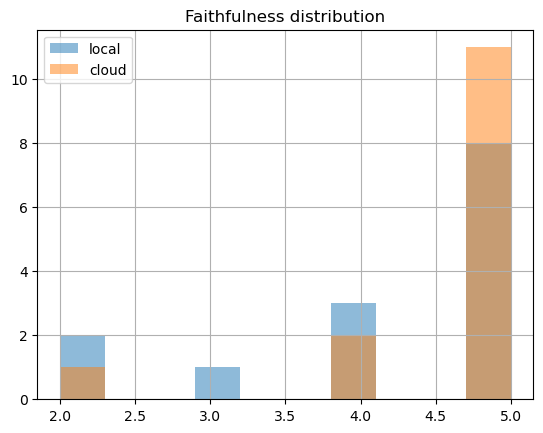

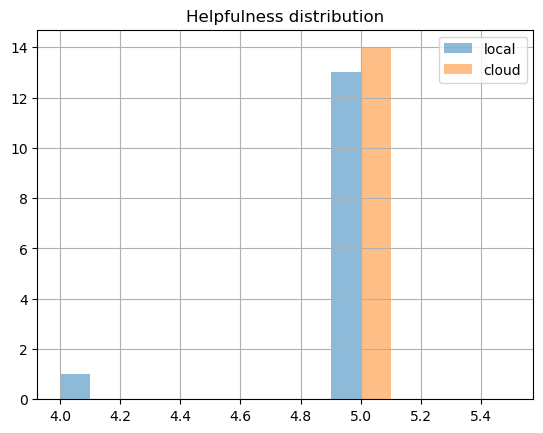

hit_at_k,miss (0),hit (1)
backend,,
cloud,1,13
local,2,12


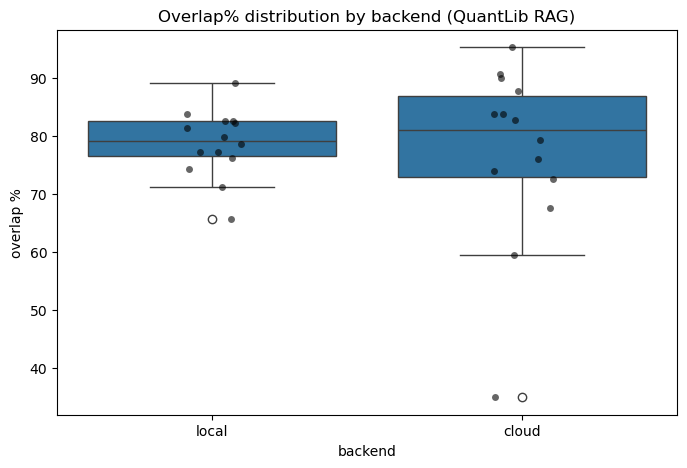

In [19]:
plt.figure()
df_all_full[df_all_full["backend"] == "local"]["faithfulness"].hist(alpha=0.5, label="local")
df_all_full[df_all_full["backend"] == "cloud"]["faithfulness"].hist(alpha=0.5, label="cloud")
plt.legend()
plt.title("Faithfulness distribution")
plt.show()

# %%
plt.figure()
df_all_full[df_all_full["backend"] == "local"]["helpfulness"].hist(alpha=0.5, label="local")
df_all_full[df_all_full["backend"] == "cloud"]["helpfulness"].hist(alpha=0.5, label="cloud")
plt.legend()
plt.title("Helpfulness distribution")
plt.show()

counts = (
    df_all_full
    .groupby("backend")["hit_at_k"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "miss (0)", 1: "hit (1)"})
)

display(counts)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.boxplot(
    x="backend",
    y="overlap_percent",
    data=df_all_full,
    showfliers=True,
)

sns.stripplot(
    x="backend",
    y="overlap_percent",
    data=df_all_full,
    jitter=True,
    color="black",
    alpha=0.6,
)

plt.title("Overlap% distribution by backend (QuantLib RAG)")
plt.ylabel("overlap %")
plt.show()


In [16]:
df_all_full.sort_values("hit_at_k")

,backend,question,gold_source,hit_at_k,faithfulness,helpfulness,judge_notes,latency_retrieval_ms,latency_llm_ms,overlap_percent,api_only_in_answer,answer_en
9,local,How can I retrieve the NPV of an instrument af...,instruments.md,0,2,5,The answer provides a helpful example of how t...,186.299324,0.032663,74.285714,[],To retrieve the NPV (Net Present Value) of an ...
8,local,How do I create a simple fixed-rate bond instr...,instruments.md,0,2,4,The answer provides a general example of creat...,181.295872,0.047684,77.173913,"[ql.Bond, ql.Schedule, ql.FixedRateCoupon, ql....",To create a simple fixed-rate bond instrument ...
23,cloud,How can I retrieve the NPV of an instrument af...,instruments.md,0,5,5,The answer is directly based on the provided c...,314.837694,11793.258905,72.500000,[],You can retrieve the NPV of an instrument afte...
0,local,How do I set up the evaluation date in QuantLib?,basics.md,1,5,5,The answer directly follows from the provided ...,175.921202,0.042200,81.250000,[],"To set up the evaluation date in QuantLib, you..."
4,local,How do I build a leg of fixed cashflows in Qua...,cashflows.md,1,5,5,The answer directly follows from the provided ...,134.687424,0.032187,77.142857,[],"To build a leg of fixed cashflows in QuantLib,..."
5,local,How can I get the payment dates and amounts fr...,cashflows.md,1,3,5,The answer provides a comprehensive solution t...,168.018579,0.029087,71.212121,[],To get the payment dates and amounts from a ca...
2,local,How do I create a QuantLib Date and convert it...,dates.md,1,4,5,The answer provides a clear and correct method...,173.912048,0.055552,82.608696,[],To create a QuantLib Date and convert it from ...
1,local,Which core QuantLib types are typically used w...,basics.md,1,5,5,The answer accurately reflects the core QuantL...,149.114132,0.029325,89.041096,[],When starting a simple pricing example in Quan...
7,local,How can I link an index to a yield term struct...,indexes.md,1,4,5,The answer provides a clear example of how to ...,138.895035,0.023603,65.714286,[ql.InterestRateIndex],To link an index to a yield term structure in ...
6,local,How do I construct an IborIndex in QuantLib?,indexes.md,1,5,5,The answer accurately reflects the information...,154.536963,0.026464,79.710145,"[ql.ActualActual, ql.Months, ql.Unadjusted]","To construct an IborIndex in QuantLib, you can..."


In [ ]:
df_local_full = local_eval.judge_existing_answers(df_local_phase1)
#df_local_phase1.to_pickle("local_phase1.pkl")

# FAZA 2 – jak masz stabilny net / chcesz Groqa
#df_local_phase1 = pd.read_pickle("local_phase1.pkl")  # opcjonalnie
